In [1]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

# Load and process Fashion MNIST data for image classification

In [2]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.38MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.23MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.84MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



#### Plot some Fashion MNIST examples

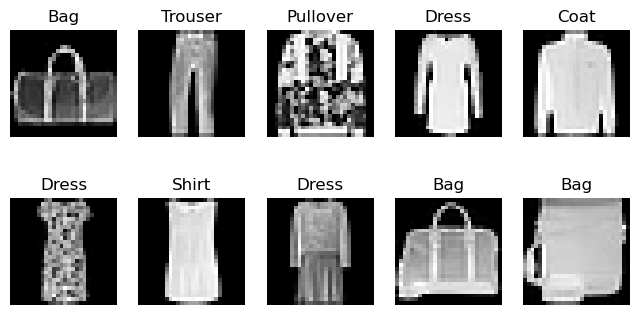

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#One batach has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

# Use PyTorch to build a neural network (multi-layer perceptron) for image classification

#### Define a class to construct all the layers in the neural network

In [4]:
np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.flatten = nn.Flatten() #Convert the image from matrix to vector
        self.fc1 = nn.Linear(784, 300) #The input layer with 784 features, and the first hidden layer with 300 neurons
        self.fc2 = nn.Linear(300, 100) #The second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 10) #The output layer with 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  #The first hidden layer uses ReLU activation function
        x = F.relu(self.fc2(x))  #The first hidden layer uses ReLU activation function
        x = self.fc3(x) #The output layer does not apply any activation function here, but will be processed directly by loss function
        return x

#### Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs

In [5]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

ClassificationNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


#### Train the model

In [6]:
#Define the training function
def train(epoch):
    model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    y_train, y_pred = [], []
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = model(features)

        loss = lossfunction(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels.long()).sum().item()
        y_train += labels.tolist()
        y_pred += train_predicted.tolist()

    macro_f1 = f1_score(y_train, y_pred, average='macro')
    print("epoch (%d): Train accuracy: %.4f, f1_score: %.4f, loss: %.3f" % (epoch, train_correct/train_total, macro_f1, running_loss/train_total))
    
    
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch)

epoch (1): Train accuracy: 0.7936, f1_score: 0.7913, loss: 0.009
epoch (2): Train accuracy: 0.8306, f1_score: 0.8294, loss: 0.007
epoch (3): Train accuracy: 0.8362, f1_score: 0.8350, loss: 0.007
epoch (4): Train accuracy: 0.8396, f1_score: 0.8384, loss: 0.007
epoch (5): Train accuracy: 0.8383, f1_score: 0.8369, loss: 0.007
epoch (6): Train accuracy: 0.8398, f1_score: 0.8384, loss: 0.007
epoch (7): Train accuracy: 0.8402, f1_score: 0.8390, loss: 0.007
epoch (8): Train accuracy: 0.8398, f1_score: 0.8388, loss: 0.007
epoch (9): Train accuracy: 0.8420, f1_score: 0.8408, loss: 0.007
epoch (10): Train accuracy: 0.8417, f1_score: 0.8408, loss: 0.007


# Evaluate the trained neural network

In [15]:
#Define the test function
def test():
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.long()).sum().item()
            y_test += labels.tolist()
            y_pred += predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))
    
    return y_test, y_pred

#Test the model
y_test, y_pred = test()

Test accuracy: 0.8288, macro f1_score: 0.8323


#### Output the confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[588   3  27  52   4   1 313   0  12   0]
 [  0 948   3  27   8   2  12   0   0   0]
 [  4   0 709  11 116   0 158   0   2   0]
 [  4   9  17 863  42   0  63   0   2   0]
 [  0   0  96  32 700   0 170   0   2   0]
 [  1   0   0   1   0 951   0  27   4  16]
 [ 54   1 105  34  52   1 739   0  14   0]
 [  0   0   0   0   0  39   0 903   0  58]
 [  0   1   0   4   5   2  41   3 943   1]
 [  0   0   0   0   0  26   0  28   2 944]]


#### Calculate accuracy, macro F1-score, and micro F1-score

In [17]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')
print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

Accuracy: 0.83
Macro F1-score: 0.83
Micro F1-score: 0.83
